In [1]:
import matplotlib
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# 1D Imaging

Imagine that we live in 2D universe (so 1D sky) and there are three point sources in the sky at locations $[l_1, l_2, l_3]$ all with the same flux of one. Now nature is continuous (at least at the scales we are probing) so we can simulate the visibilities according to a continuous Fourier transform i.e.

$$ V_{pq}(u) = \int I(l) \exp(-2\pi\imath ul) dl.  $$

For our sky consisting of three sources we have

$$ V_{pq} = \int \left(\delta(l - l_1) + \delta(l - l_2) + \delta(l - l_3)\right) \exp(-2\pi\imath ul) dl.  $$

Write a function that takes the locations of the three point sources as input and returns the visibility evaluated at $u$. 

In [2]:
def visf(u, loc1, loc2, loc3):
    return np.exp(-2j*np.pi * u * loc1) + np.exp(-2j*np.pi * u * loc2) + np.exp(-2j*np.pi * u * loc3)

Now assume you have a fictitous interferometer that measurements at uniformly random distributed locations between $u \in [-u_{max}, u_{max}] $. Choose some source locations and a value of $u_{max}$ and generate some visibilities.

In [3]:
loc1 = -0.1
loc2 = 0.1
loc3 = 0.2
nrow = 50
umax = 50.0
np.random.seed(42)
u = -umax + np.random.random(nrow) * 2 * umax
vis = visf(u, loc1, loc2, loc3)

Next we need to set up a discrete version of this operator that can be implemented as a matrix multiplication. To do so we need to set the cell size and number of pixels. Recall that, by the Nyquist criterion, we need to sample at twice the longest frequency present in the spectrum. This tells us how to set the maximum cell size. Since we have chosen the source locations ourselves, we know the required field of view and can use to determine the number of pixels that are required. We do this in the following.

In [10]:
cell = 1.0/(2*umax)  # Nyquist cell size
cell /= 2.0
fov = 0.5
npix = int(np.ceil(fov/cell))
if npix%2:  # make sure it is even
    npix += 1
print(f'npix = {npix}')
l = -fov/2 + np.arange(npix)*cell
R = np.zeros((nrow, npix), dtype=np.complex128)
for k in range(nrow):
    for i in range(npix):
        R[k, i] = np.exp(-2j*np.pi * u[k] * l[i])

print(np.linalg.matrix_rank(R))

npix = 100
50


To create an "image" from these noise free "visibilities" we write down the likelihood as

$$ \chi^2 = (y - Rx)^\dagger N^{-1} (y - Rx),  $$

where $y$ is just the vector of "visibilities" and $x$ is the image we are after. Taking the gradient and setting it to zero we find

$$ R^\dagger N^{-1} R x = R^\dagger N^{-1} y ~~ \equiv ~~ I^D = I^{psf} \star x  $$

The right hand side of this expression is known as the dirty image. We can compute it by applying the adjoint (conjugate transpose) of the above matrix to the visibilities. For now we assume that $N$ is the identity, we will see how this choice affects things later on.

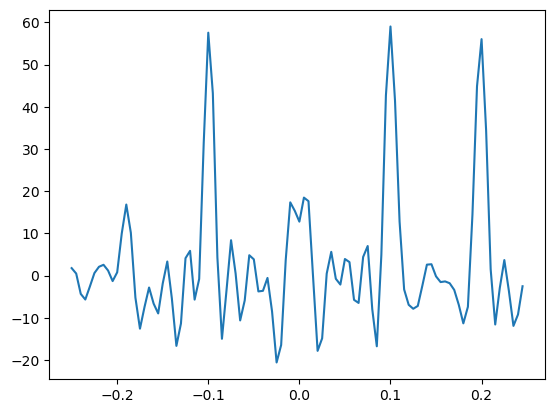

In [11]:
sigma = 1.0  # noise level
Ninv = np.eye(nrow)/sigma**2
wsum = np.sum(np.diag(Ninv))  # sum of the weights
ID = (R.conj().T.dot(Ninv.dot(vis))).real
plt.plot(l, ID)
plt.show()

Take note of the values on the y-axis. Can you explain what you are seeing? What about if you divide the dirty image by the sum of the weights?

Recall that the left hand side of the above expression (the Hessian) is an operator that implements convolution with the PSF where the PSF is defined as

$$ I^{psf} = R^\dagger N^{-1} R \delta_{l_0},  $$


where $\delta_{l_0}$ is a sky vector containing a point source at $l=0$. We can therefore compute the PSF as (why?)

$$ I^{psf} = R^\dagger diag(N^{-1}).  $$

Let's compute it and see what it looks like.

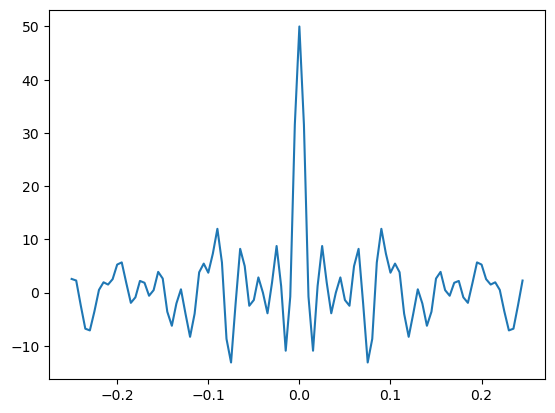

In [6]:
W = np.diag(Ninv)
PSF = R.conj().T.dot(W).real

plt.plot(l, PSF)

We can also compute the operator that implements a convolution with the PSF by explicitly constructing the matrix $R^\dagger N^{-1} R$. In this example the sources have been chosen to lie exacty at pixel locations so we can also create a vector containing the true model $x$. Let us do so below and apply our convolution operator to make sure we get the same thing.

1.7763568394002505e-13


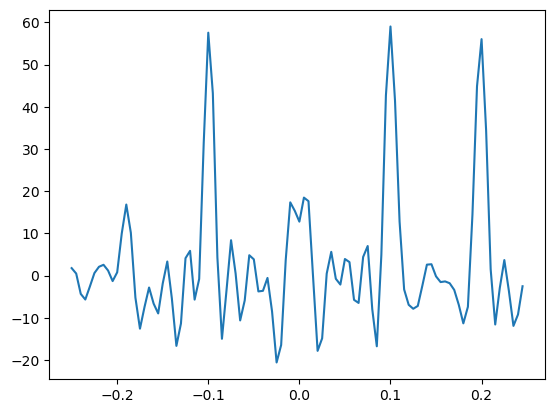

In [12]:
xsky = np.zeros(npix, dtype=float)
pixloc1 = np.where(np.abs(l - loc1) < 1e-10)
pixloc2 = np.where(np.abs(l - loc2) < 1e-10)
pixloc3 = np.where(np.abs(l - loc3) < 1e-10)
xsky[pixloc1] = 1.0
xsky[pixloc2] = 1.0
xsky[pixloc3] = 1.0

PSFc = R.conj().T.dot(Ninv.dot(R))
ID2 = PSFc.dot(xsky).real
plt.plot(l, ID2)
print(np.abs(ID - ID2).max())

Let us now confirm that this is indeed a convolution by computing the same thing using the FFT. In order for this to work we need to construct the PSF on a grid twice the size of the image (why?). 

So what we are trying to show is that

$$ R^\dagger N^{-1} R = Z^\dagger F^\dagger \hat{I}^{PSF} F Z, $$

where $Z$ is the zero padding operator, $F$ is the FFT and $\hat{I}^{PSF}$ is the FFT of the PSF computed on a grid twice the size of the image. 

We start by computing the PSF. We'll need to define a version of $R$ which maps a double sized image to visibilities. We do this in the following.

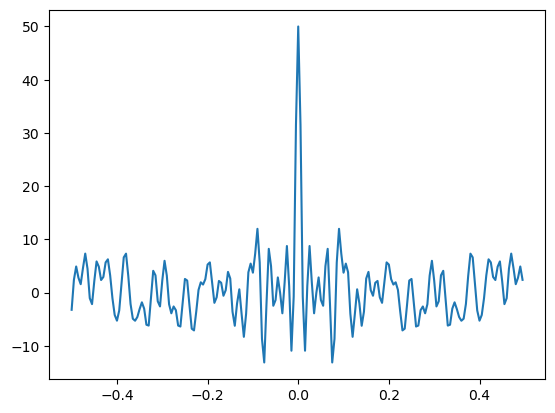

In [13]:
lpsf = -fov + np.arange(2*npix)*cell

Rpsf = np.zeros((nrow, 2*npix), dtype=np.complex128)
for k in range(nrow):
    for i in range(2*npix):
        Rpsf[k, i] = np.exp(-2j*np.pi * u[k] * lpsf[i])

PSF2 = (Rpsf.conj().T.dot(W)).real
plt.plot(lpsf, PSF2)

Next let's create a function that implements a convolution with this double sized PSF and confirm that we get the same result when applying it to our sky vector.

1.794120407794253e-13


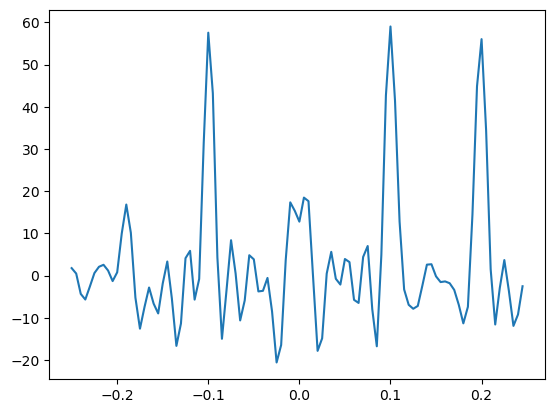

In [14]:
def psf_convolve(PSF, x):
    npix = x.size
    xpad = np.pad(x, (0, npix), mode='constant')
    xhat = np.fft.fft(xpad)
    PSFhat = np.fft.fft(np.fft.ifftshift(PSF))
    xhat *= PSFhat
    return np.fft.ifft(xhat)[0:npix].real

ID3 = psf_convolve(PSF2, xsky)
plt.plot(l, ID3)
print(np.abs(ID - ID3).max())

Finally, let us inspect the form of the operator $R^\dagger N^{-1} R$ by explicitly computing it. Do you recognize the structure?

In [ ]:
H = (R.conj().T.dot(Ninv.dot(R))).real
plt.imshow(H)
plt.colorbar()

# 1D Deconvolution

First, let us attempt to reconstruct the true sky by solving the gradient equation above and see what happens.

In [ ]:
x = np.linalg.solve(H, ID).real

plt.plot(l, x, 'kx')

What happens if we use the pseudo-inverse instead.

In [ ]:
Hpinv = np.linalg.pinv(H)
xp = Hpinv.dot(ID).real

plt.plot(l, xp, 'kx')

Now let us generate some noise and see what happens if we try the same thing.

In [ ]:
d = vis + sigma * np.random.randn(nrow)

IDn = R.conj().T.dot(Ninv.dot(d)).real
xn = np.linalg.solve(H, IDn).real

plt.plot(l, xn, 'kx')

And with the pseudo-inverse.

In [ ]:
xpn = Hpinv.dot(IDn).real
plt.plot(l, xpn, 'kx')

Noise clearly makes the inversion unstable. We need an algorithm that implements some kind of regularisation. Let's start with CLEAN.

In [ ]:
def clean(ID, PSF, gamma=0.1, threshold=0.1, maxit=5000):
    '''
    1D Hogbom CLEAN 
    '''
    nx = ID.size
    nx_psf = PSF.size
    assert nx_psf//2 == nx
    wsum = PSF.max()
    PSF /= wsum
    ID /= wsum
    Isearch = np.abs(ID)
    p = Isearch.argmax()
    Imax = Isearch[p]
    IR = ID.copy()
    IM = np.zeros(nx)
    k = 0
    while (k < maxit) and (Imax > threshold):
        # update model
        IM[p] += IR[p] * gamma
        
        # subtract PSF centered at component
        IR -= PSF[nx - p:nx + nx - p] * IR[p] * gamma
        
        # find new peak
        Isearch = np.abs(IR)
        p = Isearch.argmax()
        Imax = Isearch[p]

    if k == maxit:
        print('Warning - max iters reached')

    return IM, IR



model_clean, residual_clean = clean(IDn.copy(), PSF2.copy())

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(l, model_clean, 'kx')
ax[1].plot(l, residual_clean)

Now for some Tikhonov regularisation obtained by solving

$$ x = (R^\dagger N^{-1} R + \eta I)^{-1} I^D,  $$

where $\eta > 0$ is some small positive number used to regularise the problem and $I$ here denotes the identity.

In [ ]:
eta = 0.001
model_tikhonov = np.linalg.solve(H + eta*np.eye(npix), IDn)
residual_tikhonov = IDn - H.dot(model_tikhonov)

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(l, model_tikhonov, 'kx')
ax[1].plot(l, residual_tikhonov/wsum)

What about some sparsity? Because we know where the sources are, we can cheat and solve for their fluxes at pixel locations only, implicitly setting all other pixels to zero. We can do this by modifying our measurement operator as follows:

In [ ]:
lsparse = np.array([loc1, loc2, loc3])
Rs = np.zeros((nrow, 3), dtype=np.complex128)
for k in range(nrow):
    for i in range(3):
        Rs[k, i] = np.exp(-2j*np.pi * u[k] * lsparse[i])

IDs = Rs.conj().T.dot(Ninv.dot(d)).real
Hs = Rs.conj().T.dot(Ninv.dot(Rs)).real
Is = np.linalg.solve(Hs, IDs)

print(Is.sum())

model_sparse = np.zeros(npix)
model_sparse[pixloc1] = Is[0]
model_sparse[pixloc2] = Is[1]
model_sparse[pixloc3] = Is[2]
residual_sparse = IDn - H.dot(model_sparse)

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(l, model_sparse, 'kx')
ax[1].plot(l, residual_sparse/wsum)